# Building a Convolutional Neural Network

## Imports & Helper Functions

In [ ]:
import os
# import csv
import time
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
import torchvision
# from torch import nn, optim
# import torch.nn.functional as F
# import torchvision.transforms as transforms
# from torchvision.datasets import ImageFolder
# from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import train_test_split

## Check & Define Device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


## Load Data

In [ ]:
# skip if local
from google.colab import drive 
drive.mount('/content/drive')

# change directory for local support in subesquent cells
%cd //content/drive/MyDrive/DS_projects/LD_copsForPortfolio/ML_skipception

Mounted at /content/drive
/content/drive/MyDrive/DS_projects/LD_copsForPortfolio/ML_skipception


In [ ]:
# unzip dataset
!unzip "datasets/tiny-imagenet-30.zip" -d "/content/tiny-imagenet-30" &> /dev/null

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = ImageFolder(root="/content/tiny-imagenet-30/train_set", 
                      transform=transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 100000
    Root location: /content/tiny-imagenet-200/train_set
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [ ]:
image_ids = []
classes = [] 

# open txt file and read lines
mapping = open('/content/tiny-imagenet-30/words.txt', 'r')
lines = mapping.readlines()

# split lines and save to respective lists
for line in lines:
  image_ids.append(line.split('\t')[0])
  classes.append(line.split('\t')[1])

classes = [x.strip() for x in classes]

In [ ]:
print(classes)

['goldfish, Carassius auratus', 'European fire salamander, Salamandra salamandra', 'bullfrog, Rana catesbeiana', 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui', 'American alligator, Alligator mississipiensis', 'boa constrictor, Constrictor constrictor', 'trilobite', 'scorpion', 'black widow, Latrodectus mactans', 'tarantula', 'centipede', 'goose', 'koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus', 'jellyfish', 'brain coral', 'snail', 'slug', 'sea slug, nudibranch', 'American lobster, Northern lobster, Maine lobster, Homarus americanus', 'spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish', 'black stork, Ciconia nigra', 'king penguin, Aptenodytes patagonica', 'albatross, mollymawk', 'dugong, Dugong dugon', 'Chihuahua', 'Yorkshire terrier', 'golden retriever', 'Labrador retriever', 'German shepherd, German shepherd dog, German police dog, alsatian', 'standard poodle', 'tabby, tabby cat', 'Persian cat', 'Egyptian cat', 'cougar

In [ ]:
batch = 64

# define indicies so that we can stratify our splits
train_indices, val_indices, _, _ = train_test_split(
    range(len(fine_dataset)),
    fine_dataset.targets,
    stratify=fine_dataset.targets,
    test_size=0.2,
    random_state=0
)

# create subset with indices
train_split = Subset(fine_dataset, train_indices)
val_split = Subset(fine_dataset, val_indices)

# create batch loaders
train_batches = DataLoader(train_split, 
                           batch_size=batch, 
                           shuffle=True)

val_batches = DataLoader(val_split, 
                          batch_size=batch, 
                          shuffle=False)
# Report split sizes
print('Training batch has {} instances'.format(len(train_batches)))
print('Validation batch has {} instances'.format(len(val_batches)))

## View Data

In [ ]:
# Helper function for inline image display
def matplotlib_imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_batches)
images, labels = dataiter.next()

dataiter = iter(train_batches)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images[0:6])
matplotlib_imshow(img_grid, one_channel=False)
print(' - '.join(classes[labels[j]] for j in range(6)))

## Motivation

Our goal is to design a convolutional neural network that can learn the features of a dataset consisting of 64x64 images and accurately separate each image into one of 200 classes. In order to develop a model that does not introduce unnecessary complexity, we will use a method of architecture design called "single-batch training". Single-batch training entails iteratively designing a model that will, hopefully, intentionally overfit a single training batch of data. If the model is able to easily overfit a single training batch, we can assume that the architecture is complex enough to learn the features of our dataset.

After finding an architecture that overfits for a single batch, we can train our network on the entire training dataset and adjust for overfitting through regularization techniques.

## Single-Batch training

### Define Network

In [ ]:
# define a Model class
class Classifier_114(nn.Module):
    
    def __init__(self, num_classes=200):
        super(Classifier_114, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5)
        
        self.fc1 = nn.Linear(12 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))

        x = x.reshape(x.size(0), -1) # flatten the input

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Instantiate Model

In [ ]:
# instantiate your Model class
model_114_single = Classifier_114()

In [ ]:
model_114_single.to(device)

Classifier_114(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2028, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=200, bias=True)
)

### Train Model

In [ ]:
def train_one(model, optimizer, loss_fn, train_inputs, train_labels, val_dl, epochs=100, device='cpu', save_dir=None, save_filename=None):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        optimizer.zero_grad()

        x    = train_inputs.to(device)
        y    = train_labels.to(device)
        yhat = model(x)
        loss = loss_fn(yhat, y)

        loss.backward()
        optimizer.step()

        train_loss         += loss.data.item() * x.size(0)
        num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
        num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_inputs)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)

        if epoch == 1 or epoch % 1 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [ ]:
# Define Loss Function and Optimizer
epochs=75
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_114.parameters(), lr=0.001)

# get one batch of training data                    
train_inputs, train_labels = next(iter(train_batches))

# clear gpu memory 
torch.cuda.empty_cache()
history = train_one(model_114_single, optimizer, loss_fn, train_inputs, train_labels, val_batches, epochs, device)

train() called: model=Classifier_114, opt=Adam(lr=0.001000), epochs=75, device=cuda:0
Epoch   1/ 75, train loss:  5.28, train acc:  0.02, val loss:  5.30, val acc:  0.00
Epoch   2/ 75, train loss:  5.27, train acc:  0.05, val loss:  5.30, val acc:  0.01
Epoch   3/ 75, train loss:  5.26, train acc:  0.03, val loss:  5.30, val acc:  0.01
Epoch   4/ 75, train loss:  5.23, train acc:  0.03, val loss:  5.31, val acc:  0.01
Epoch   5/ 75, train loss:  5.20, train acc:  0.03, val loss:  5.31, val acc:  0.01
Epoch   6/ 75, train loss:  5.15, train acc:  0.03, val loss:  5.32, val acc:  0.01
Epoch   7/ 75, train loss:  5.09, train acc:  0.03, val loss:  5.36, val acc:  0.01
Epoch   8/ 75, train loss:  4.99, train acc:  0.03, val loss:  5.43, val acc:  0.01
Epoch   9/ 75, train loss:  4.87, train acc:  0.03, val loss:  5.58, val acc:  0.01
Epoch  10/ 75, train loss:  4.74, train acc:  0.03, val loss:  5.89, val acc:  0.01
Epoch  11/ 75, train loss:  4.65, train acc:  0.03, val loss:  6.28, val a

### Single-Batch Model Metrics

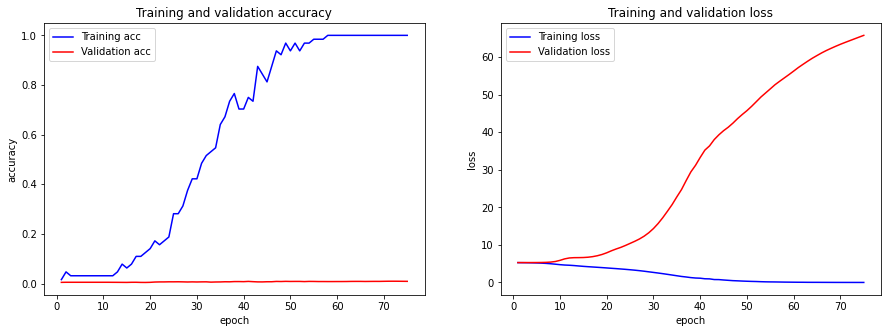

In [ ]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(epochs, acc, 'b', label='Training acc')
ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'b', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend()
plt.show()

## Training on Complete Dataset

### Instantiate Model
Train your overfitting model ```model_114``` on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.

> As in previous sections, please leave the graph clearly displayed.

In [ ]:
# instantiate Model class
model_114_full = Classifier_114()

In [ ]:
model_114_full.to(device)

Classifier_114(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2028, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=200, bias=True)
)

### Train Model

In [ ]:
def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu', save_dir=None, save_filename=None):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s, save_dir=%s%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device, save_dir, save_filename))

    history = {} # Collects per-epoch loss and acc
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        if epoch == 1 or epoch % 1 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)
    
        # ----------- SAVE -----------
        if save_dir != None and ((epoch)%20 == 0):
          results_path = os.path.join(save_dir, f'{save_filename}_ep{epoch}.pt')

          state = {'epoch': epoch, 
                   'model_state_dict': model.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict()
                   }

          try:
            torch.save(state, results_path)
            print(f'Model @ epoch {epoch} saved to {results_path}')
          except Exception:
            print(f'Model @ epoch {epoch} not saved')
            pass

    # END OF TRAINING LOOP

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [ ]:
# Define Loss Function and Optimizer
epochs=75
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_114_full.parameters(), lr=0.001)

# clear gpu memory 
torch.cuda.empty_cache()
history = train(model_114_full, optimizer, loss_fn, train_batches, val_batches, epochs, device)

train() called: model=Classifier_114, opt=Adam(lr=0.001000), epochs=75, device=cuda:0, save_dir=NoneNone

Epoch   1/ 75, train loss:  4.99, train acc:  0.03, val loss:  4.75, val acc:  0.05
Epoch   2/ 75, train loss:  4.58, train acc:  0.07, val loss:  4.45, val acc:  0.09
Epoch   3/ 75, train loss:  4.36, train acc:  0.10, val loss:  4.32, val acc:  0.10
Epoch   4/ 75, train loss:  4.20, train acc:  0.11, val loss:  4.24, val acc:  0.11
Epoch   5/ 75, train loss:  4.07, train acc:  0.13, val loss:  4.17, val acc:  0.12
Epoch   6/ 75, train loss:  3.96, train acc:  0.15, val loss:  4.07, val acc:  0.14
Epoch   7/ 75, train loss:  3.87, train acc:  0.16, val loss:  4.00, val acc:  0.14
Epoch   8/ 75, train loss:  3.80, train acc:  0.17, val loss:  3.98, val acc:  0.15
Epoch   9/ 75, train loss:  3.74, train acc:  0.18, val loss:  3.96, val acc:  0.15
Epoch  10/ 75, train loss:  3.69, train acc:  0.19, val loss:  3.98, val acc:  0.15
Epoch  11/ 75, train loss:  3.65, train acc:  0.19, va

### Complete Dataset Model Metrics

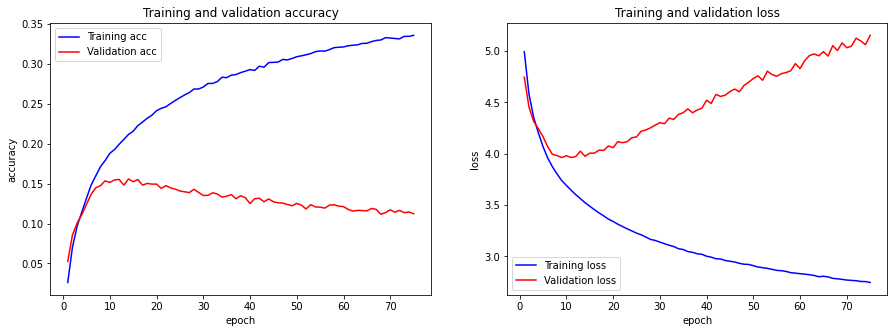

In [ ]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(epochs, acc, 'b', label='Training acc')
ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'b', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend()
plt.show()

### Finetune Model

Now finetune your architecture by implementing at least 2 methods of reducing overfitting and increasing the model's ability to generalise. You are welcome to further adjust the model after you have done the minimum requirement, to increase your model performance.

**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

If you adjust the Model class, redefine it below and instantiate it as ```model_122a```, ```model_122b```, and so on.

#### Transform & Split Data

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

fine_dataset = ImageFolder(root="/content/tiny-imagenet-200/train_set", 
                      transform=transform)

print(fine_dataset)

Dataset ImageFolder
    Number of datapoints: 100000
    Root location: /content/tiny-imagenet-200/train_set
    StandardTransform
Transform: Compose(
               ToTensor()
               ColorJitter(brightness=[0.8, 1.2], contrast=None, saturation=[0.8, 1.2], hue=[-0.2, 0.2])
               RandomAffine(degrees=[-10.0, 10.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
               RandomHorizontalFlip(p=0.5)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
batch = 64

# define indicies so that we can stratify our splits
train_indices, val_indices, _, _ = train_test_split(
    range(len(fine_dataset)),
    fine_dataset.targets,
    stratify=fine_dataset.targets,
    test_size=0.2,
    random_state=0
)

# create subset with indices
train_split = Subset(fine_dataset, train_indices)
val_split = Subset(fine_dataset, val_indices)

# create batch loaders
train_batches = DataLoader(train_split, 
                           batch_size=batch, 
                           shuffle=True)

val_batches = DataLoader(val_split, 
                          batch_size=batch, 
                          shuffle=False)

#### View Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sock - rocking chair, rocker - seashore, coast, seacoast, sea-coast - golden retriever - dam, dike, dyke - goose


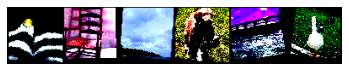

In [ ]:
dataiter = iter(train_batches)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images[0:6])
matplotlib_imshow(img_grid, one_channel=False)
print(' - '.join(classes[labels[j]] for j in range(6)))

#### Define Finetunned Network

In [ ]:
# define a Model class
class Classifier_122j(nn.Module):
    
    def __init__(self, num_classes=30):
        super(Classifier_122j, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=9, padding='same')
        self.conv1_bn=nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, padding='same')
        self.conv2_bn=nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')        
        self.conv3_bn=nn.BatchNorm2d(128)


        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128*8*8, 4096)
        self.fc2 = nn.Linear(4096, 2048)      
        self.fc3 = nn.Linear(2048, num_classes)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))        
        x = self.pool(x)

        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))        
        x = self.pool(x)

        
        x = x.reshape(x.size(0), -1) # flatten the input
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Instantiate Model

In [ ]:
# instantiate new Model class
model_122j = Classifier_122j()

In [ ]:
model_122j.to(device)

Classifier_122j(
  (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=same)
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=200, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

#### Train Model

In [ ]:
# Define Loss Function and Optimizer
epochs=100
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_122j.parameters(), lr=0.001, momentum=0.9)


history = train(model_122j, optimizer, loss_fn, train_batches, val_batches, epochs, device)

train() called: model=Classifier_122j, opt=SGD(lr=0.001000), epochs=100, device=cuda:0, save_dir=NoneNone

Epoch   1/100, train loss:  5.09, train acc:  0.02, val loss:  4.87, val acc:  0.04
Epoch   2/100, train loss:  4.66, train acc:  0.06, val loss:  4.55, val acc:  0.08
Epoch   3/100, train loss:  4.30, train acc:  0.10, val loss:  4.23, val acc:  0.11
Epoch   4/100, train loss:  4.07, train acc:  0.13, val loss:  3.99, val acc:  0.14
Epoch   5/100, train loss:  3.92, train acc:  0.15, val loss:  3.89, val acc:  0.16
Epoch   6/100, train loss:  3.80, train acc:  0.17, val loss:  3.78, val acc:  0.17
Epoch   7/100, train loss:  3.69, train acc:  0.19, val loss:  3.66, val acc:  0.19
Epoch   8/100, train loss:  3.60, train acc:  0.20, val loss:  3.54, val acc:  0.22
Epoch   9/100, train loss:  3.52, train acc:  0.21, val loss:  3.60, val acc:  0.20
Epoch  10/100, train loss:  3.44, train acc:  0.23, val loss:  3.50, val acc:  0.22
Epoch  11/100, train loss:  3.37, train acc:  0.24, v

In [ ]:
state = {'epoch': 100, 'model_state_dict': model_122j.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}

torch.save(state, '/content/drive/MyDrive/DS_projects/LD_copsForPortfolio/ML_skipception/models/saved_models/cnn-122j_ep100_TN200.pt')

#### Finetuned Model Metrics

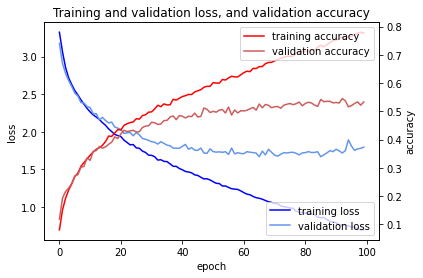

In [ ]:
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(epochs, acc, 'b', label='Training acc')
ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'b', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend()
plt.show()

In [ ]:
# ----------- LOAD -----------
results_path = 'models/saved_models/cnn-122j_ep100_TN200.pt'

model_122j = Classifier_122j()
optimizer = optim.SGD(model_122j.parameters(), lr=0.001, momentum=0.9)

checkpoint = torch.load(results_path)
model_122j.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

model_122j.eval()

Classifier_122j(
  (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=same)
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=200, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

#### Test Finetuned Model
Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. 